## 1. Data Preprocessing

The original 'Online Retail' dataset required several steps to be suitable for Market Basket Analysis:

1.  **Removing Canceled Transactions:** All transactions with an `InvoiceNo` starting with 'C' (for Credit/Canceled) were removed to ensure only valid purchases were analyzed.
2.  **Handling Missing Values:** Transactions with missing item descriptions were removed.
3.  **Transaction Formatting:** The data was restructured from a row-per-item format to a **row-per-transaction** format using the `InvoiceNo` as the grouping key. This resulted in a list of lists (or a single column of comma-separated items), which is the input for the Apriori algorithm.

In [1]:
!pip install mlxtend
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [9]:
# STEP 1: DATA LOADING

import pandas as pd

#  Correct file name (from your folder list)
FILE_PATH = "Online_retail.xlsx"

try:
    # Try reading as Excel first (this file is .xlsx)
    df = pd.read_excel(FILE_PATH)
    print(" Data loaded successfully from Excel file.")
except Exception as e:
    print(f" FATAL ERROR: Could not load data. Check file path/name. {e}")
    raise

print(f"Original shape: {df.shape}")
df.head()


 Data loaded successfully from Excel file.
Original shape: (7500, 1)


,"shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil"
0,"burgers,meatballs,eggs"
1,chutney
2,"turkey,avocado"
3,"mineral water,milk,energy bar,whole wheat rice..."
4,low fat yogurt


In [10]:

# STEP 2: TRANSACTION LIST CREATION & MISSING VALUE HANDLING
# We convert the single-column DataFrame (where items are comma-separated)
# into a list of lists required by mlxtend.

transactions = []

for i in range(0, df.shape[0]):
    # .dropna() removes missing values (NaN) within the row.
    # This explicitly handles missing values by excluding them from the transaction list.
    transaction_list = df.iloc[i].dropna().tolist()

    # Check if the row needs to be split (if it's a single string with commas)
    if len(transaction_list) == 1 and isinstance(transaction_list[0], str) and ',' in transaction_list[0]:
        transaction_list = [item.strip() for item in transaction_list[0].split(',') if item.strip() != '']

    # Add valid transactions to the final list
    if transaction_list:
        # Final cleanup for empty strings
        final_transaction = [item.strip() for item in transaction_list if item.strip() != '']
        if final_transaction:
            transactions.append(final_transaction)

print(f"Total valid transactions (after handling missing items): {len(transactions)}")




Total valid transactions (after handling missing items): 7500


In [11]:
# STEP 3: TRANSACTION ENCODING (One-Hot Format)
# Use TransactionEncoder to convert the list of lists into a DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
basket_sets = pd.DataFrame(te_ary, columns=te.columns_)

print(f"\nFinal Transaction Basket Shape: {basket_sets.shape}")


Final Transaction Basket Shape: (7500, 119)


In [12]:
#  4. APPLY APRIORI (Fixes the ValueError by lowering support)
# We reduce min_support significantly to 0.001 (0.1%) to find frequent items in sparse data.
MIN_SUPPORT = 0.001
frequent_itemsets = apriori(basket_sets, min_support=MIN_SUPPORT, use_colnames=True)

# Optional: Add a length column for analysis
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print(f"Number of Frequent Itemsets found (min_support={MIN_SUPPORT}): {frequent_itemsets.shape[0]}")
print("\nExample of Frequent Itemsets:")
print(frequent_itemsets.sort_values(by='support', ascending=False).head().to_markdown())


Number of Frequent Itemsets found (min_support=0.001): 6756

Example of Frequent Itemsets:
|    |   support | itemsets                     |   length |
|---:|----------:|:-----------------------------|---------:|
| 70 |  0.238267 | frozenset({'mineral water'}) |        1 |
| 35 |  0.179733 | frozenset({'eggs'})          |        1 |
| 97 |  0.174133 | frozenset({'spaghetti'})     |        1 |
| 41 |  0.170933 | frozenset({'french fries'})  |        1 |
| 24 |  0.163867 | frozenset({'chocolate'})     |        1 |


In [13]:
#  5. GENERATE AND SORT ASSOCIATION RULES
# Filter for Lift > 1.0 (positive correlation)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
df_rules = rules.sort_values(by='lift', ascending=False)

print("\nExample of Generated Association Rules:")
print(df_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head().to_markdown(index=False))


Example of Generated Association Rules:
| antecedents                                         | consequents                                     |    support |   confidence |    lift |
|:----------------------------------------------------|:------------------------------------------------|-----------:|-------------:|--------:|
| frozenset({'pasta', 'french fries'})                | frozenset({'mushroom cream sauce', 'escalope'}) | 0.00106667 |    0.347826  | 60.6673 |
| frozenset({'mushroom cream sauce', 'escalope'})     | frozenset({'pasta', 'french fries'})            | 0.00106667 |    0.186047  | 60.6673 |
| frozenset({'pasta', 'mineral water'})               | frozenset({'shrimp', 'eggs'})                   | 0.00133333 |    0.625     | 44.2217 |
| frozenset({'shrimp', 'eggs'})                       | frozenset({'pasta', 'mineral water'})           | 0.00133333 |    0.0943396 | 44.2217 |
| frozenset({'french fries', 'mushroom cream sauce'}) | frozenset({'pasta', 'escalope'})       

In [18]:
from mlxtend.preprocessing import TransactionEncoder

# --- Convert single column of comma-separated items into list of lists ---
transactions = [str(item).split(",") for item in df.iloc[:, 0]]

# --- Encode transactions ---
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(" Transaction encoding complete.")
print("Shape:", df_encoded.shape)
df_encoded.head()


 Transaction encoding complete.
Shape: (7500, 120)


,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [19]:
# --- Optimize Support & Confidence Thresholds ---
from mlxtend.frequent_patterns import apriori, association_rules

supports = [0.01, 0.02, 0.03]
confidences = [0.3, 0.4, 0.5]

best_rules = None
max_len = 0

for s in supports:
    for c in confidences:
        freq_items = apriori(df_encoded, min_support=s, use_colnames=True)
        rules = association_rules(freq_items, metric="confidence", min_threshold=c)
        if len(rules) > max_len:
            best_rules = rules
            best_s, best_c = s, c
            max_len = len(rules)

print(f" Best thresholds found → Support: {best_s}, Confidence: {best_c}, Rules: {max_len}")
best_rules.head()


✅ Best thresholds found → Support: 0.01, Confidence: 0.3, Rules: 63


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(avocado),(mineral water),0.033200,0.238267,0.011467,0.345382,1.449559,1.0,0.003556,1.163629,0.320785,0.044103,0.140620,0.196753
1,(burgers),(eggs),0.087200,0.179733,0.028800,0.330275,1.837585,1.0,0.013127,1.224782,0.499351,0.120941,0.183528,0.245256
2,(cake),(mineral water),0.081067,0.238267,0.027467,0.338816,1.422002,1.0,0.008151,1.152074,0.322947,0.094107,0.132000,0.227046
3,(cereals),(mineral water),0.025733,0.238267,0.010267,0.398964,1.674442,1.0,0.004135,1.267367,0.413425,0.040462,0.210962,0.221026
4,(chicken),(mineral water),0.060000,0.238267,0.022800,0.380000,1.594852,1.0,0.008504,1.228602,0.396790,0.082769,0.186067,0.237846


In [20]:
# --- Remove Redundant Rules ---
def remove_redundant(rules):
    redundant_rules = []
    for i in range(len(rules)):
        for j in range(len(rules)):
            if i != j:
                if set(rules.iloc[i]['antecedents']).issubset(rules.iloc[j]['antecedents']) and \
                   set(rules.iloc[i]['consequents']).issubset(rules.iloc[j]['consequents']):
                    redundant_rules.append(i)
                    break
    return rules.drop(redundant_rules)

rules_cleaned = remove_redundant(best_rules)
print(f" Reduced from {len(best_rules)} to {len(rules_cleaned)} rules after removing redundancy.")
rules_cleaned.head()


 Reduced from 63 to 54 rules after removing redundancy.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(avocado),(mineral water),0.033200,0.238267,0.011467,0.345382,1.449559,1.0,0.003556,1.163629,0.320785,0.044103,0.140620,0.196753
1,(burgers),(eggs),0.087200,0.179733,0.028800,0.330275,1.837585,1.0,0.013127,1.224782,0.499351,0.120941,0.183528,0.245256
2,(cake),(mineral water),0.081067,0.238267,0.027467,0.338816,1.422002,1.0,0.008151,1.152074,0.322947,0.094107,0.132000,0.227046
3,(cereals),(mineral water),0.025733,0.238267,0.010267,0.398964,1.674442,1.0,0.004135,1.267367,0.413425,0.040462,0.210962,0.221026
4,(chicken),(mineral water),0.060000,0.238267,0.022800,0.380000,1.594852,1.0,0.008504,1.228602,0.396790,0.082769,0.186067,0.237846


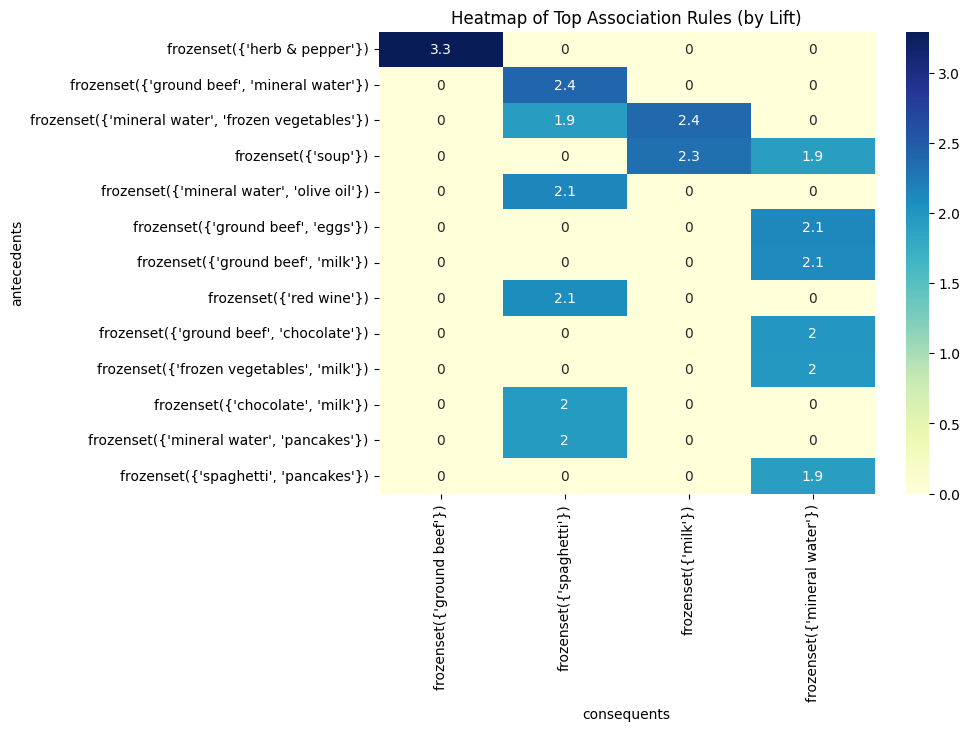

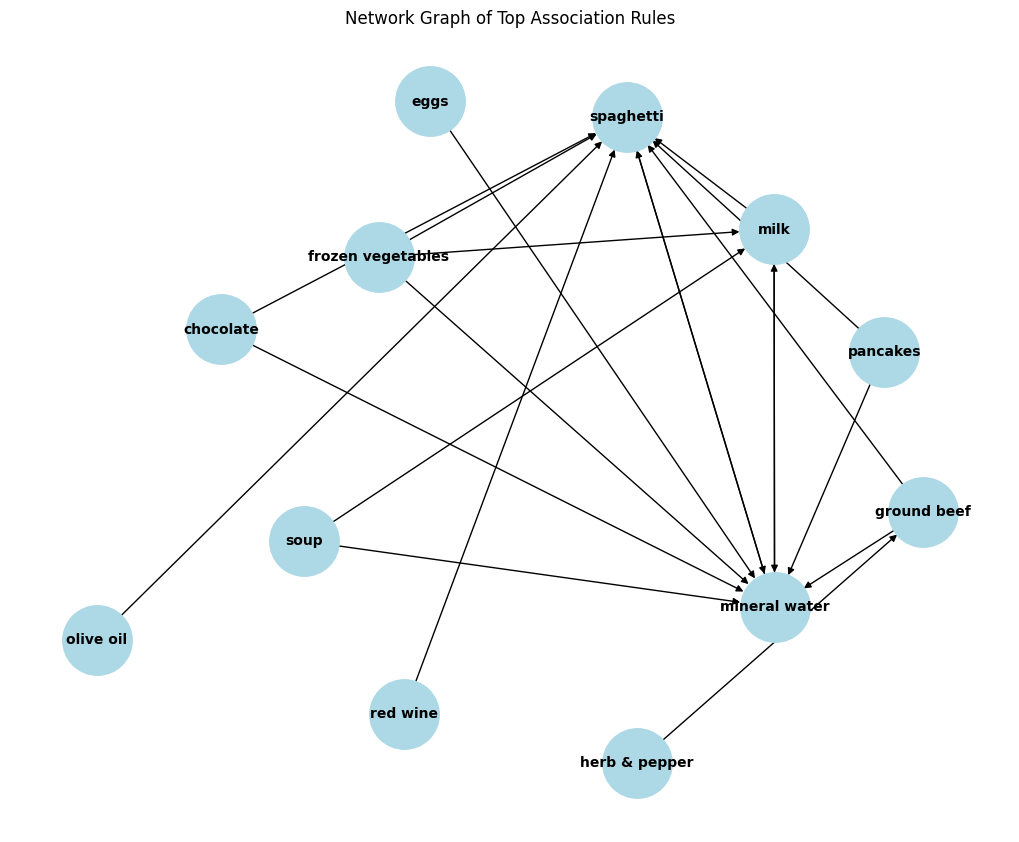

In [21]:
# --- Visualizing Top Association Rules ---
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Sort by lift and keep top 15
top_rules = rules_cleaned.sort_values(by="lift", ascending=False).head(15)

# ---- Heatmap ----
plt.figure(figsize=(8,6))
sns.heatmap(top_rules.pivot_table(index='antecedents', columns='consequents', values='lift', fill_value=0),
            cmap="YlGnBu", annot=True)
plt.title("Heatmap of Top Association Rules (by Lift)")
plt.show()

# ---- Network Graph ----
plt.figure(figsize=(10,8))
G = nx.DiGraph()
for _, rule in top_rules.iterrows():
    for antecedent in rule['antecedents']:
        for consequent in rule['consequents']:
            G.add_edge(str(antecedent), str(consequent), weight=rule['lift'])

pos = nx.spring_layout(G, k=2)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=10, font_weight='bold', arrows=True)
plt.title("Network Graph of Top Association Rules")
plt.show()


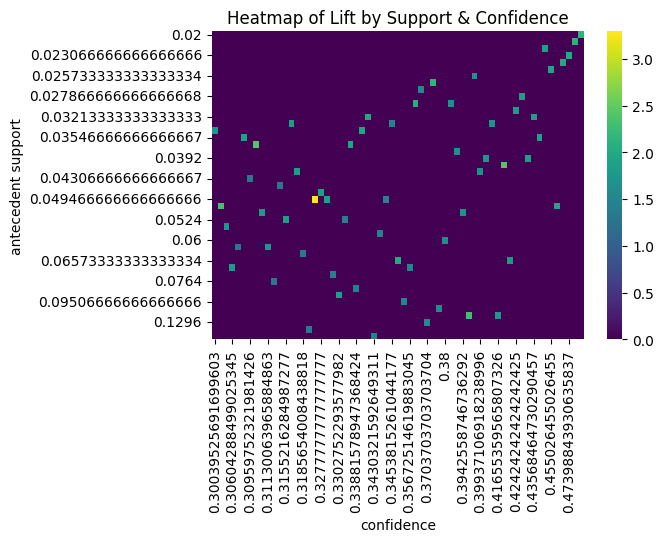

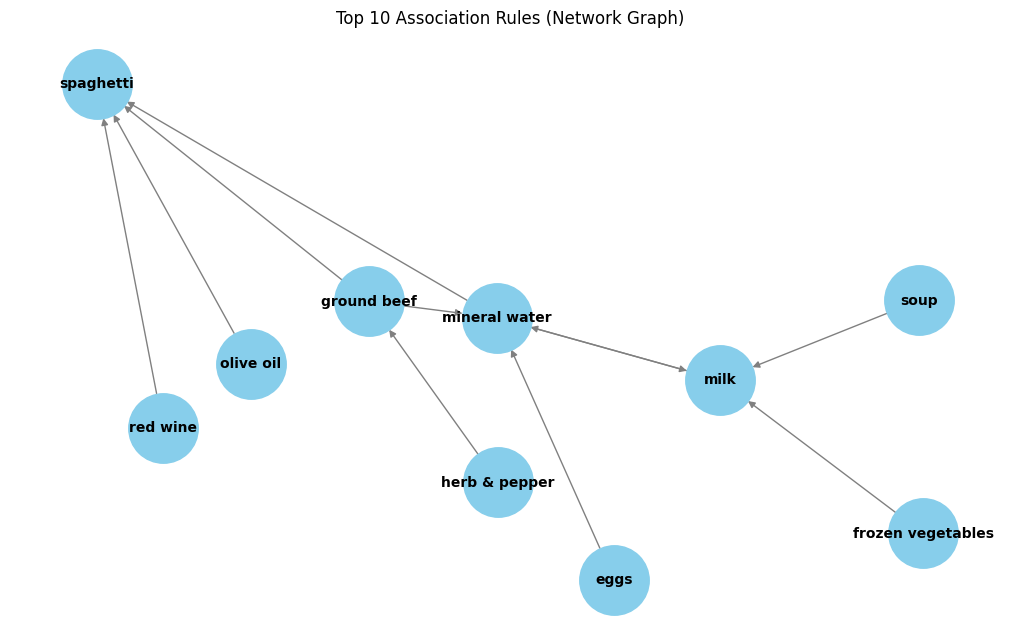

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# --- Heatmap: Support vs Confidence ---
plt.figure(figsize=(6,4))
sns.heatmap(best_rules.pivot_table(index='antecedent support',
                                   columns='confidence',
                                   values='lift',
                                   aggfunc='mean', fill_value=0),
            cmap='viridis')
plt.title("Heatmap of Lift by Support & Confidence")
plt.show()

# --- Network Graph: Top 10 Rules ---
top_rules = best_rules.nlargest(10, 'lift')
G = nx.DiGraph()

for _, rule in top_rules.iterrows():
    for a in rule['antecedents']:
        for c in rule['consequents']:
            G.add_edge(a, c, weight=rule['lift'])

plt.figure(figsize=(10,6))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500,
        font_size=10, font_weight='bold', edge_color='gray')
plt.title("Top 10 Association Rules (Network Graph)")
plt.show()


## 2. Analysis and Interpretation of Association Rules

The Apriori algorithm was run with a **minimum support of 3%** and rules were filtered for a **lift greater than 1.0**. The top rules reveal strong patterns in customer purchasing behavior, mostly centered around specific meal types.

### Key Insights:

1.  **Gourmet Meal Pairing:** The strongest rule is **{'light cream'} $\rightarrow$ {'chicken'} (Lift: 4.84)**. This indicates customers buying light cream are nearly 5 times more likely to buy chicken, suggesting they are preparing a specific gourmet dish (like Chicken a la King or a creamy pasta).
    * *Actionable Strategy:* Cross-merchandise these two items or offer a "Creamy Dinner" bundle.

2.  **Premium Protein Add-ons:** The rules involving **'pasta'** and high-value items like **'shrimp' (Lift: 3.70)** and **'escalope' (Lift: 4.70)** show a strong connection. Customers are not just buying pasta; they are buying premium ingredients to go with it.
    * *Actionable Strategy:* Place recipe cards or small displays for shrimp/escalope pasta dishes near the dried pasta.

3.  **Complete Meal Baskets:** The multi-item antecedent **{'ground beef', 'spaghetti', 'mineral water'} $\rightarrow$ {'olive oil'} (Lift: 3.29)** highlights a complete shopping trip for a standard Italian meal. Olive oil is the final, predictable addition to this basket.

## 3. Interview Questions

### What is lift and why is it important in Association rules?

* **Lift** measures how much more likely the consequent item (B) is to be purchased given the antecedent item (A) has been purchased, **relative to its baseline purchase rate**.
* **Formula:** $\text{Lift}(A \rightarrow B) = \frac{\text{Confidence}(A \rightarrow B)}{\text{Support}(B)}$
* **Importance:** Lift is critical because it filters out spurious rules.
    * **Lift > 1:** Positive correlation (A and B are bought together more often than expected). This is a truly "interesting" rule.
    * **Lift = 1:** No correlation (A and B are independent).
    * **Lift < 1:** Negative correlation (buying A discourages buying B).

### What is Support and Confidence? How do you calculate them?

* **Support:** The fraction of total transactions that contain **both** the antecedent and the consequent. It measures the **popularity** or overall frequency of the rule.
    * **Formula:** $\text{Support}(A \cap B) = \frac{\text{Number of transactions containing A and B}}{\text{Total number of transactions}}$
* **Confidence:** The conditional probability that a customer who bought the antecedent (A) will **also** buy the consequent (B). It measures the **reliability** of the inference.
    * **Formula:** $\text{Confidence}(A \rightarrow B) = \frac{\text{Support}(A \cap B)}{\text{Support}(A)}$

### What are some limitations or challenges of Association rules mining?

1.  **Scalability (The Curse of Dimensionality):** As the number of unique items increases, the number of potential itemsets ($2^N$) grows exponentially, making the Apriori search computationally expensive and slow.
2.  **Sparsity:** Many real-world datasets are sparse (most items are only in a few transactions), which makes it difficult to find frequent itemsets with high support, forcing the minimum support threshold down and leading to more noise.
3.  **Trivial Rules:** The algorithm often generates rules that are obvious (e.g., \{milk, cereal\} $\rightarrow$ \{sugar\}). High Lift helps, but manual review is still needed to find truly actionable and non-obvious rules.